# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex

## Dataset import

In [ ]:
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "reggae")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

In [7]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [8]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/rap_lyrics.parquet",
    index=False
)

In [4]:
# Chargement du df filtré
df = pd.read_parquet("data/rap_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Descriptive statistics

In [ ]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
RangeIndex: 964605 entries, 0 to 964604
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   title   964538 non-null  str  
 1   artist  964605 non-null  str  
 2   year    964605 non-null  int64
 3   views   964605 non-null  int64
 4   lyrics  964605 non-null  str  
dtypes: int64(2), str(3)
memory usage: 2.1 GB


In [11]:
# Dupes check in df
df[df.duplicated(subset=["title", "artist"], keep=False)] \
  .sort_values(["artist", "title"])

,title,artist,year,views,lyrics
754298,WHERES WALDO 2,C.M.L.,2020,5955,"[Mozzy and DJ Vlad Interview]\nVlad: So, how l..."
801101,WHERES WALDO 2,C.M.L.,2021,73,U was laughing at bris now im laughing at sque...
149155,You I,Marsha Ambrosius,2014,240,[Hook]\nYou and I\nCan we get together now\nYo...
149171,You I,Marsha Ambrosius,2014,255,[Chorus]\nYou and I\nCan we get together now?\...
587407,Trauma Grace,Medhane,2019,1806,In between tomorrow and today\nSunshine and im...
593930,Trauma Grace,Medhane,2020,86,[Verse 1]\nIn between tomorrow and today\nSuns...


In [ ]:
# Removing dupes
df = df.drop_duplicates(subset=["title", "artist"], keep="first")
df.shape

In [ ]:
# Descriptive statistics for numerics columns
df[["year", "views"]].describe()
# Incoherence in values for year and views (min)

,year,views
count,964605.000000,9.646050e+05
mean,2014.790266,5.882038e+03
std,57.264063,8.041827e+04
min,1.000000,0.000000e+00
25%,2015.000000,2.000000e+01
50%,2018.000000,6.900000e+01
75%,2020.000000,5.280000e+02
max,2027.000000,1.757563e+07


In [12]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1    649
2      6
3      3
5      1
6      6
Name: count, dtype: int64

In [6]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(963628, 5)

In [7]:
df["year"].describe()
# Now, the values make sense

count    963628.000000
mean       2016.463142
std           5.523159
min        1950.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

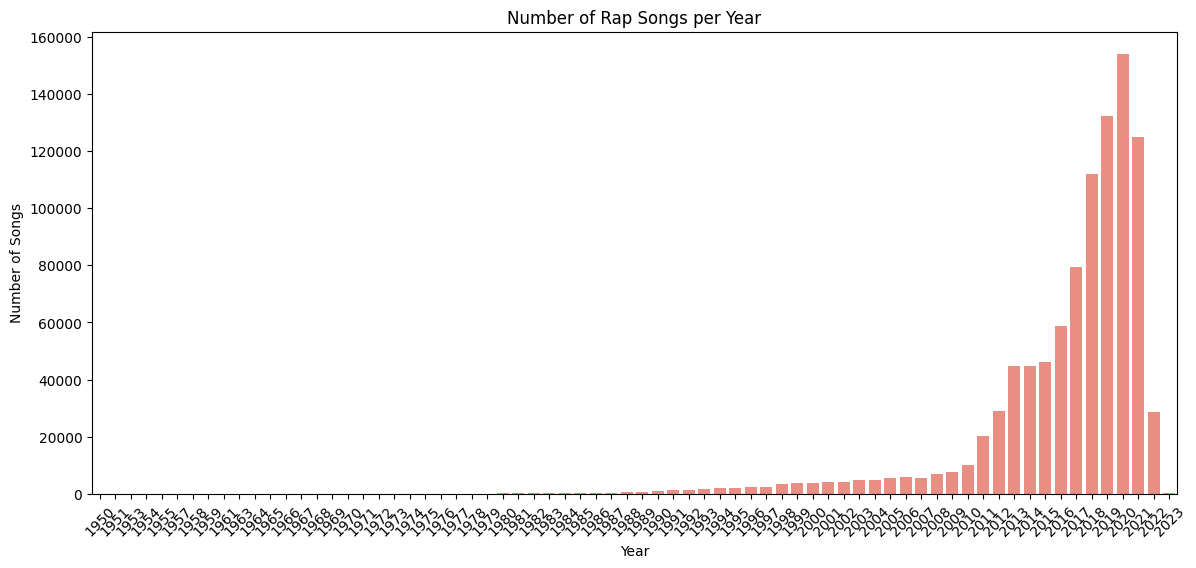

In [4]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Keeping rows only from the year 1980 to 2023
df = df[(df["year"] >= 1980) & (df["year"] <= 2023)]
df["year"].describe()

count    963336.000000
mean       2016.476295
std           5.471202
min        1980.000000
25%        2015.000000
50%        2018.000000
75%        2020.000000
max        2023.000000
Name: year, dtype: float64

In [ ]:
df["artist"].value_counts().head(10)
# Genius English Translations needs to be removed (the originals songs are not in English)

artist
Genius English Translations    3738
Lil B                          1287
Gucci Mane                     1184
Juice WRLD                     1135
Lil Wayne                      1020
Chief Keef                      919
Muze Sikk                       917
OCTOBERSFULLMOON                886
Kanye West                      773
BONES                           773
Name: count, dtype: int64

In [16]:
# Removing Genius translations
mask_artist = ~df["artist"].str.contains(
    "Genius|Translation|Translations",
    case=False,
    na=False
)

# Removing lyrics too small
#mask_length = df["clean_lyrics"].str.split().str.len() >= 50

# Filter
df = df[mask_artist 
        #& mask_length
        ]

# Check
df["artist"].value_counts().head(10)

artist
Lil B               1287
Gucci Mane          1184
Juice WRLD          1135
Lil Wayne           1020
Chief Keef           919
Muze Sikk            917
OCTOBERSFULLMOON     886
Kanye West           773
BONES                773
Young Thug           761
Name: count, dtype: int64

In [ ]:
# Quick check of the title and count coherence
df[df["artist"] == "Lil B"]["title"].value_counts().head(20)

title
Look Like Jesus                  1
I Look Like Hannah Montana       1
Swag Jerry Rice                  1
Wonton Soup                      1
Bitch Im Bill Clinton            1
Hoes on My Dick                  1
New York Subway                  1
Santa Coming Christmas Spirit    1
Rich Ho                          1
B.O.R. Birth of Rap              1
I Got Bitches                    1
D.O.R. Death of Rap              1
Pretty Boy                       1
The Age of Information           1
Hipster Girls                    1
Exhibit 6                        1
Exhibit Based                    1
Slangin Yayo                     1
Im Heem                          1
Cook Steak Knife                 1
Name: count, dtype: int64

In [17]:
# Shape
df.shape

(957980, 5)

## Lyrics pre processing

In [19]:
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# View of clean lyrics
print(df["clean_lyrics"].head())
print(df["clean_lyrics"].loc[1])

0    killa cam killa cam cam killa cam killa cam ki...
1    yeah hah yeah roc fella invite somethin epic k...
2    maybe cause eatin bastards fiend grub carry pu...
3    ugh killa baby kanye heron flow huh yeah let s...
4    ask young boy gon second time around gon come ...
Name: clean_lyrics, dtype: str
yeah hah yeah roc fella invite somethin epic know well hustle sense hopelessness sort desperation desperation become addicted sort like fiends accustomed servin feel nothin lose offer well offer lives right bring table watchin every nigga watchin closely shit butter bread wanna toast keep head supposed hoes get sidetracked clapped close feet sleep tired feel wired like codeine days brother gotta admire four fiends away pain wish quick see sellin caine til brains fried fricassee lie time never bothered bar gettin thug properly squad lack respect authority laughin hard happy escapin poverty however brief know game got valleys peaks expectation dips precipitation stack chips hardly youth 

In [24]:
df.to_parquet(
    "data/rap_lyrics_nlp_clean.parquet",
    index=False
)

In [25]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/rap_lyrics_nlp_clean.parquet"
)

## Sentiment Analysis - Vader

In [ ]:
# On fixe le nombre total de chansons à 50 000
total_songs = 50_000
years = df['year'].sort_values().unique()
n_years = len(years)

# Calcul du nombre de chansons par année (environ égal)
songs_per_year = total_songs // n_years

# On crée un nouveau DF avec les chansons les plus vues par année
df_top = (
    df
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(songs_per_year)
)

print(f"Total songs selected: {len(df_top)}")
df_top["year"].value_counts().sort_index()


Total songs selected: 48085


year
2000    2083
2001    2083
2002    2083
2003    2083
2004    2083
2005    2083
2006    2083
2007    2083
2008    2083
2009    2083
2010    2083
2011    2083
2012    2083
2013    2083
2014    2083
2015    2083
2016    2083
2017    2083
2018    2083
2019    2083
2020    2083
2021    2083
2022    2083
2023     176
Name: count, dtype: int64

In [27]:
MAX_PER_YEAR = 4000   
START_YEAR = 1980
END_YEAR = 2023

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_top))
df_top["year"].value_counts().sort_index()

Total songs selected: 116331


year
1980     181
1981     160
1982     266
1983     319
1984     247
1985     283
1986     276
1987     300
1988     568
1989     747
1990     851
1991    1173
1992    1329
1993    1594
1994    2123
1995    2160
1996    2379
1997    2491
1998    3255
1999    3675
2000    3778
2001    4000
2002    4000
2003    4000
2004    4000
2005    4000
2006    4000
2007    4000
2008    4000
2009    4000
2010    4000
2011    4000
2012    4000
2013    4000
2014    4000
2015    4000
2016    4000
2017    4000
2018    4000
2019    4000
2020    4000
2021    4000
2022    4000
2023     176
Name: count, dtype: int64

In [28]:
df_top["rank_within_year"] = df_top.groupby("year")["views"].rank(method="first", ascending=False)
# par contre, on a pas la date des views, donc la chanson a pu être populaire à une autre année

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df_top["sentiment"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_top["sentiment_neg"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_top["sentiment_pos"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_top["sentiment_neu"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [32]:
df_top.to_parquet(
    "data/rap_lyrics_vader.parquet",
    index=False
)

In [ ]:
# Import of clean lyrics + sentiment vader df
df_top = pd.read_parquet(
    "data/rap_lyrics_vader.parquet"
)

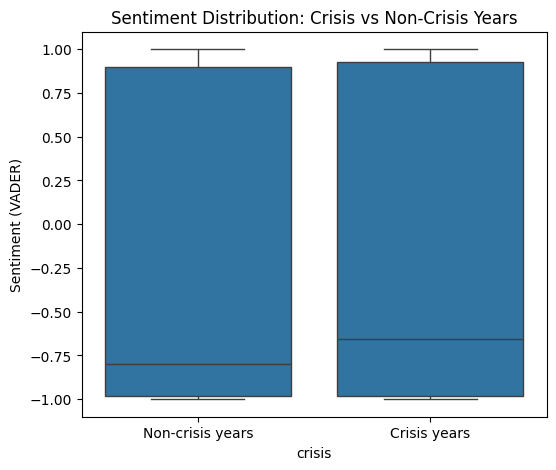

In [34]:
crisis_years = [
    1991,  # Gulf War
    2001,  # 9/11
    2008, 2009,  # Financial crisis
    2020, 2021  # COVID
]

df_top["crisis"] = df_top["year"].isin(crisis_years)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=df_top,
    x="crisis",
    y="sentiment"
)

plt.xticks([0,1], ["Non-crisis years", "Crisis years"])
plt.title("Sentiment Distribution: Crisis vs Non-Crisis Years")
plt.ylabel("Sentiment (VADER)")
plt.show()


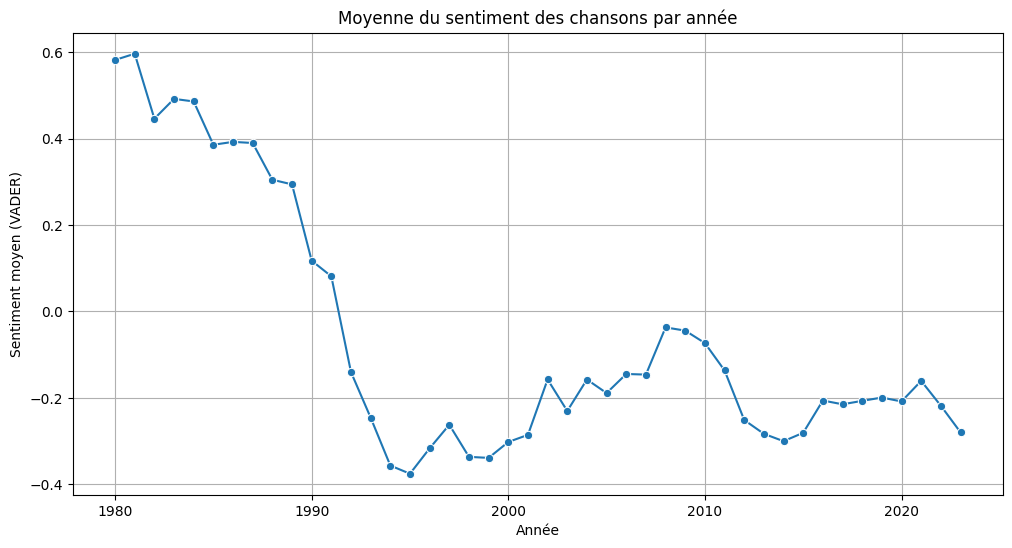

In [35]:
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o")
plt.title("Moyenne du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.grid(True)
plt.show()

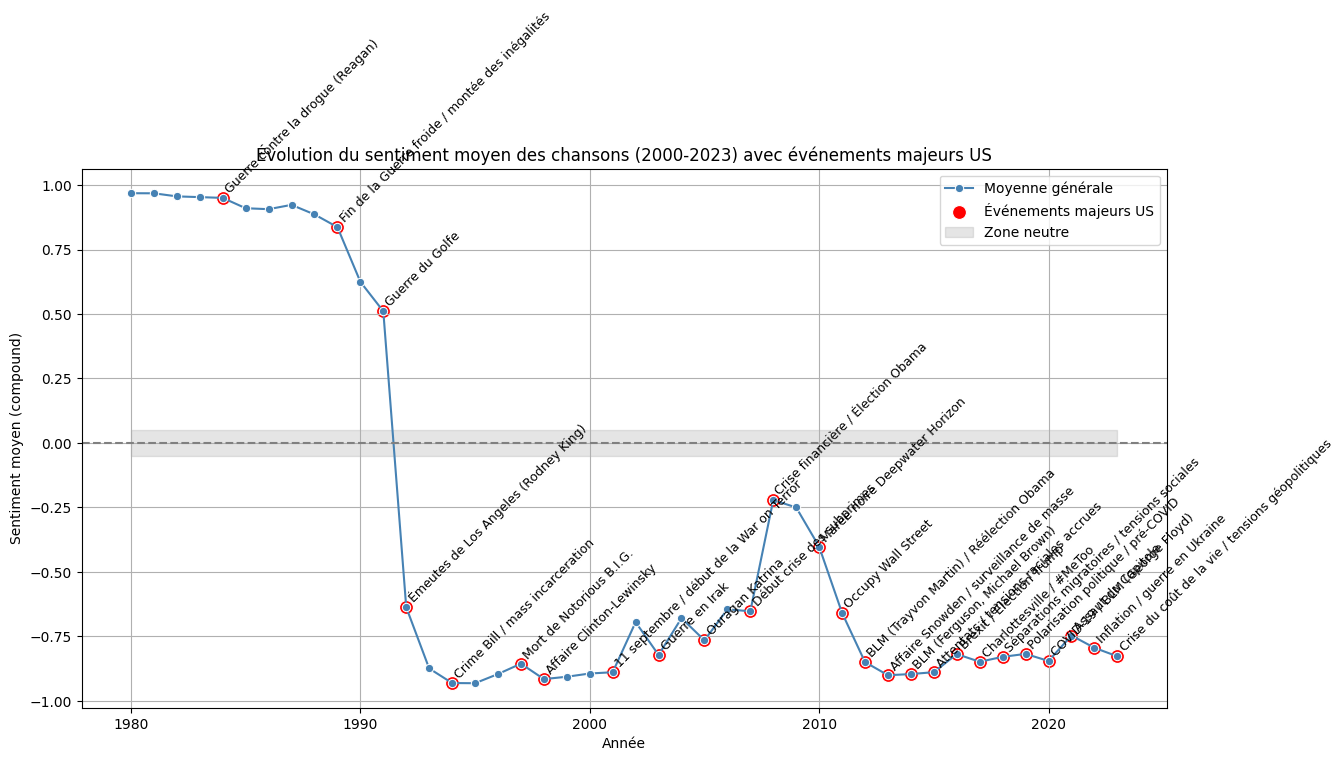

In [37]:
# Calcul du sentiment moyen par année pour tout le df_top
sentiment_year = df_top.groupby("year")["sentiment"].median()

# Filtrer le df pour les années des événements US
us_event_years = {
    # Années 1980
    1984: "Guerre contre la drogue (Reagan)",
    1989: "Fin de la Guerre froide / montée des inégalités",
    # Années 1990
    1991: "Guerre du Golfe",
    1992: "Émeutes de Los Angeles (Rodney King)",
    1994: "Crime Bill / mass incarceration",
    1997: "Mort de Notorious B.I.G.",
    1998: "Affaire Clinton-Lewinsky",
    # Années 2000
    2001: "11 septembre / début de la War on Terror",
    2003: "Guerre en Irak",
    2005: "Ouragan Katrina",
    2007: "Début crise des subprimes",
    2008: "Crise financière / Élection Obama",
    # Années 2010
    2010: "Marée noire Deepwater Horizon",
    2011: "Occupy Wall Street",
    2012: "BLM (Trayvon Martin) / Réélection Obama",
    2013: "Affaire Snowden / surveillance de masse",
    2014: "BLM (Ferguson, Michael Brown)",
    2015: "Attentats / tensions raciales accrues",
    2016: "Brexit / Élection Trump",
    2017: "Charlottesville / #MeToo",
    2018: "Séparations migratoires / tensions sociales",
    2019: "Polarisation politique / pré-COVID",
    # Années 2020
    2020: "COVID-19 / BLM (George Floyd)",
    2021: "Assaut du Capitole",
    2022: "Inflation / guerre en Ukraine",
    2023: "Crise du coût de la vie / tensions géopolitiques"
}

df_us_events = df_top[df_top["year"].isin(us_event_years.keys())]
sentiment_us_events = df_us_events.groupby("year")["sentiment"].median()

# Graphique
plt.figure(figsize=(14,7))

# Ligne sentiment moyen général
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o", color="steelblue", label="Moyenne générale")

# Points pour années clés US
sns.scatterplot(x=sentiment_us_events.index, y=sentiment_us_events.values, color="red", s=100, label="Événements majeurs US")

# Ajouter les annotations pour chaque événement
for year, event in us_event_years.items():
    if year in sentiment_us_events.index:
        plt.text(year, sentiment_us_events.loc[year] + 0.02, event, rotation=45, fontsize=9, ha='left')

# Ligne neutre
plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre")

# Labels et titre
plt.title("Évolution du sentiment moyen des chansons (2000-2023) avec événements majeurs US")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (compound)")
plt.legend()
plt.grid(True)
plt.show()

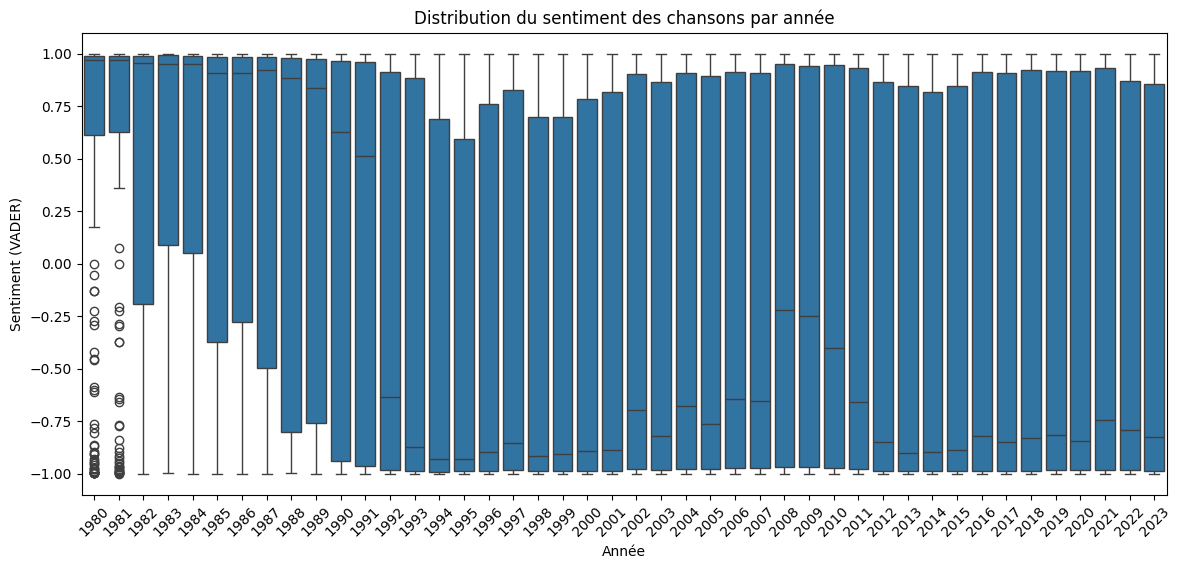

In [38]:
# Boxplots per year
plt.figure(figsize=(14,6))
sns.boxplot(x="year", y="sentiment", data=df_top)
plt.title("Distribution du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment (VADER)")
plt.xticks(rotation=45)
plt.show()

In [39]:
# Statistiques par année
year_stats = (
    df_top
    .groupby("year")
    .agg(
        sentiment_median=("sentiment", "median"),
        sentiment_mean=("sentiment", "mean"),
        n_songs=("sentiment", "size")
    )
)

event_years = list(us_event_years.keys())

year_stats_events = year_stats.loc[
    year_stats.index.isin(event_years)
]

In [41]:
year_stats["is_crisis"] = year_stats.index.isin(event_years)

year_stats.groupby("is_crisis").apply(
    lambda x: np.average(
        x["sentiment_mean"],
        weights=x["n_songs"]
    )
)


is_crisis
False   -0.160789
True    -0.201187
dtype: float64

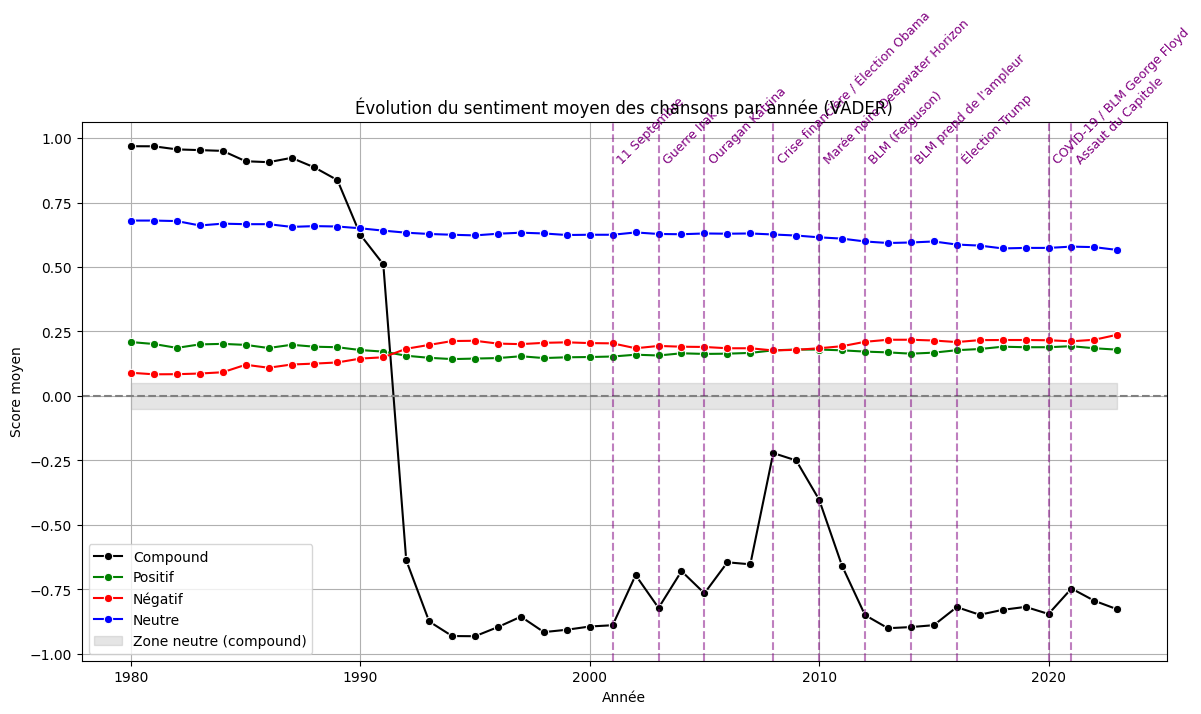

In [42]:
# Scores mean/median per years
sentiment_by_year = df_top.groupby("year")[
    ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]
].median()

plt.figure(figsize=(14,7))

sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment"], 
             marker="o", color="black", label="Compound")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_pos"], 
             marker="o", color="green", label="Positif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neg"], 
             marker="o", color="red", label="Négatif")
sns.lineplot(x=sentiment_by_year.index, y=sentiment_by_year["sentiment_neu"], 
             marker="o", color="blue", label="Neutre")

plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_by_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Zone neutre (compound)")

us_event_years = {
    2001: "11 Septembre",
    2003: "Guerre Irak",
    2005: "Ouragan Katrina",
    2008: "Crise financière / Élection Obama",
    2010: "Marée noire Deepwater Horizon",
    2012: "BLM (Ferguson)",
    2014: "BLM prend de l'ampleur",
    2016: "Élection Trump",
    2020: "COVID-19 / BLM George Floyd",
    2021: "Assaut du Capitole"
}
for year, event in us_event_years.items():
    if year in sentiment_by_year.index:
        plt.axvline(year, color="purple", linestyle="--", alpha=0.5)
        plt.text(year+0.1, 0.9, event, rotation=45, fontsize=9, color="purple")

plt.title("Évolution du sentiment moyen des chansons par année (VADER)")
plt.xlabel("Année")
plt.ylabel("Score moyen")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Mean and median of Vader scores per year
sentiment_stats = df_top.groupby("year")[["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]].agg(
    ["mean", "median"]
)

print(sentiment_stats)

     sentiment          sentiment_pos         sentiment_neg          \
          mean   median          mean  median          mean  median   
year                                                                  
2000 -0.382867 -0.92145      0.161279  0.1495      0.222041  0.2145   
2001 -0.283030 -0.90620      0.162769  0.1535      0.215889  0.2045   
2002 -0.146547 -0.68080      0.176817  0.1630      0.198195  0.1885   
2003 -0.123873 -0.63305      0.189087  0.1685      0.194889  0.1865   
2004 -0.159701 -0.74300      0.176493  0.1650      0.193930  0.1870   
2005 -0.094373 -0.56160      0.185918  0.1730      0.190788  0.1820   
2006 -0.156108 -0.67050      0.176974  0.1665      0.192647  0.1875   
2007  0.015869  0.14030      0.193983  0.1845      0.181091  0.1690   
2008  0.023268  0.11915      0.199192  0.1875      0.181654  0.1720   
2009 -0.062020 -0.39580      0.197517  0.1895      0.198060  0.1875   
2010 -0.098984 -0.52580      0.195856  0.1880      0.204351  0.2005   
2011 -

In [43]:
year_stats = (
    df_top
    .groupby("year")
    .agg(
        sentiment_mean=("sentiment", "mean"),
        sentiment_median=("sentiment", "median"),
        n_songs=("sentiment", "size")
    )
)

# Pondération
weighted_sentiment_global = (
    (year_stats["sentiment_mean"] * year_stats["n_songs"]).sum()
    / year_stats["n_songs"].sum()
)

weighted_sentiment_global


np.float64(-0.18979994928265037)

In [44]:
year_stats = year_stats.sort_index()

year_stats["weighted_cumulative_sentiment"] = (
    (year_stats["sentiment_mean"] * year_stats["n_songs"]).cumsum()
    / year_stats["n_songs"].cumsum()
)


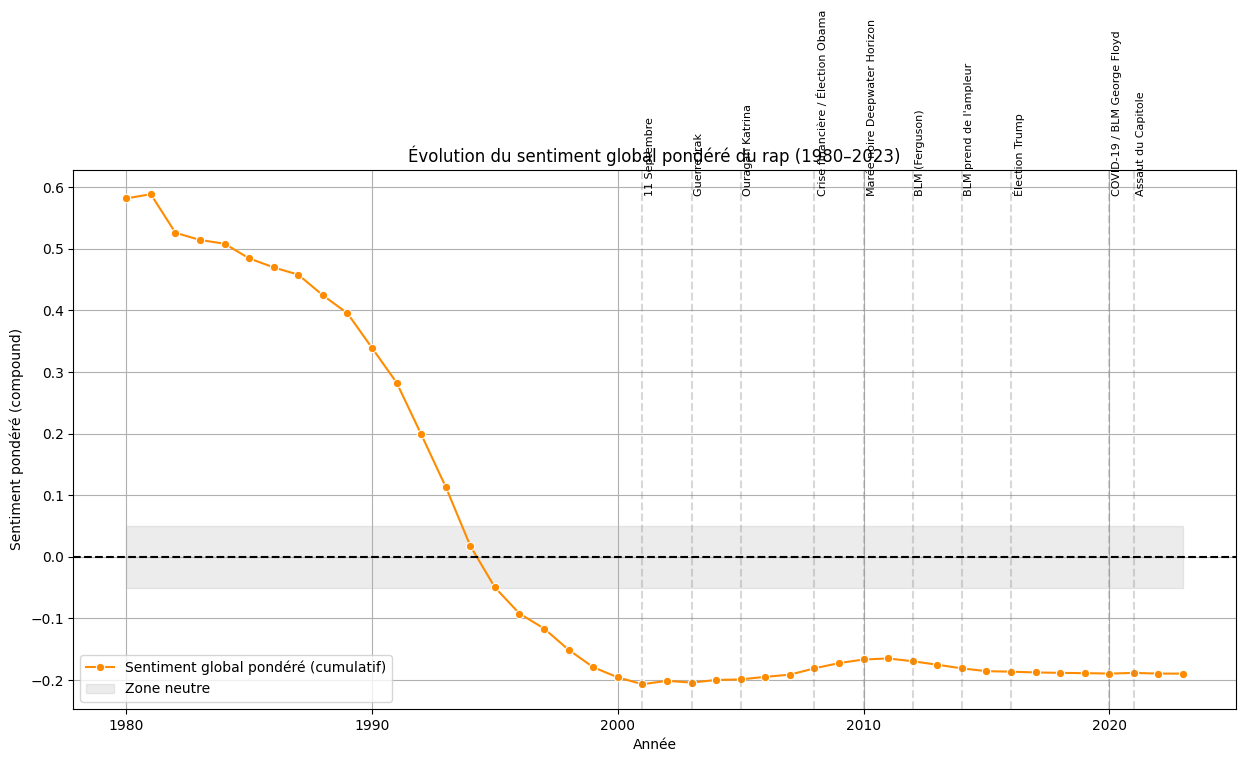

In [ ]:
plt.figure(figsize=(15,7))

# Sentiment pondéré cumulatif
sns.lineplot(
    x=year_stats.index,
    y=year_stats["weighted_cumulative_sentiment"],
    marker="o",
    color="darkorange",
    label="Sentiment global pondéré (cumulatif)"
)

# Lignes verticales pour événements
for year, label in us_event_years.items():
    if year in year_stats.index:
        plt.axvline(year, linestyle="--", alpha=0.3, color="gray")
        plt.text(
            year + 0.1,
            year_stats["weighted_cumulative_sentiment"].max(),
            label,
            rotation=90,
            fontsize=8
        )

# Zone neutre VADER
plt.axhline(0, color="black", linestyle="--")
plt.fill_between(
    year_stats.index,
    -0.05,
    0.05,
    color="gray",
    alpha=0.15,
    label="Zone neutre"
)

# Labels
plt.title("Évolution du sentiment global pondéré du rap (1980-2023)")
plt.xlabel("Année")
plt.ylabel("Sentiment pondéré (compound)")
plt.legend()
plt.grid(True)

plt.show()

## Analysis emotional power - NRC

In [49]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger") 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [51]:
python -m textblob.download_corpora

SyntaxError: invalid syntax (2621292756.py, line 1)

In [52]:
# Charger le lexique
nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

# On ne garde que les mots associés à une émotion
nrc = nrc[nrc["association"] == 1]

# Créer un dictionnaire {mot: [emotions]}
from collections import defaultdict

nrc_dict = defaultdict(list)
for _, row in nrc.iterrows():
    nrc_dict[row["word"]].append(row["emotion"])

In [53]:
from collections import Counter

def nrc_score(text, lexicon=nrc_dict):
    tokens = text.lower().split()  # on tokenise simplement par espace
    emotion_counts = Counter()
    
    for token in tokens:
        for emotion in lexicon.get(token, []):
            emotion_counts[emotion] += 1
    
    total = sum(emotion_counts.values())
    if total == 0:
        # Aucun mot associé trouvé, on retourne 0 pour chaque émotion
        return {e: 0 for e in [
            "anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"
        ]}
    
    # Normaliser par le total
    return {k: v/total for k, v in emotion_counts.items()}


In [54]:
# Limiter éventuellement à 1000 mots par texte pour accélérer
df_top["nrc_scores"] = df_top["clean_lyrics"].apply(lambda x: nrc_score(x[:1000]))

# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

# Exemple : voir les 5 premières lignes
df_top[["anger","joy","sadness","positive","negative"]].head()

,anger,joy,sadness,positive,negative
0,0.088608,0.063291,0.037975,0.126582,0.101266
1,0.028986,0.246377,0.043478,0.289855,0.086957
2,0.104167,0.052083,0.093750,0.093750,0.229167
3,0.074468,0.117021,0.074468,0.255319,0.085106
4,0.050000,0.087500,0.025000,0.350000,0.050000


In [55]:
# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

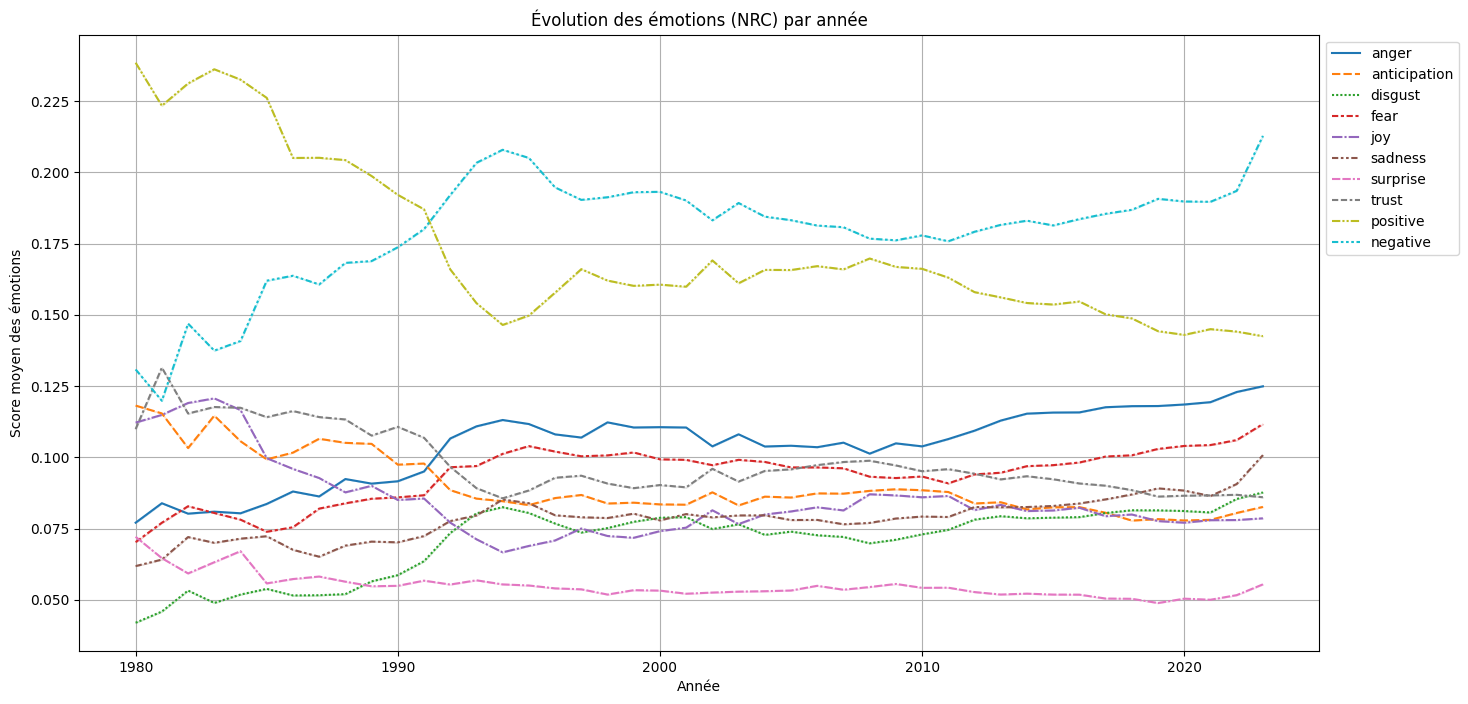

In [56]:
# Moyenne par année
emotion_year = df_top.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year)
plt.title("Évolution des émotions (NRC) par année")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

In [ ]:
# Moyenne par année pondérée
emotion_year_p = df_top.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year_p)
plt.title("Évolution des émotions (NRC) par année")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

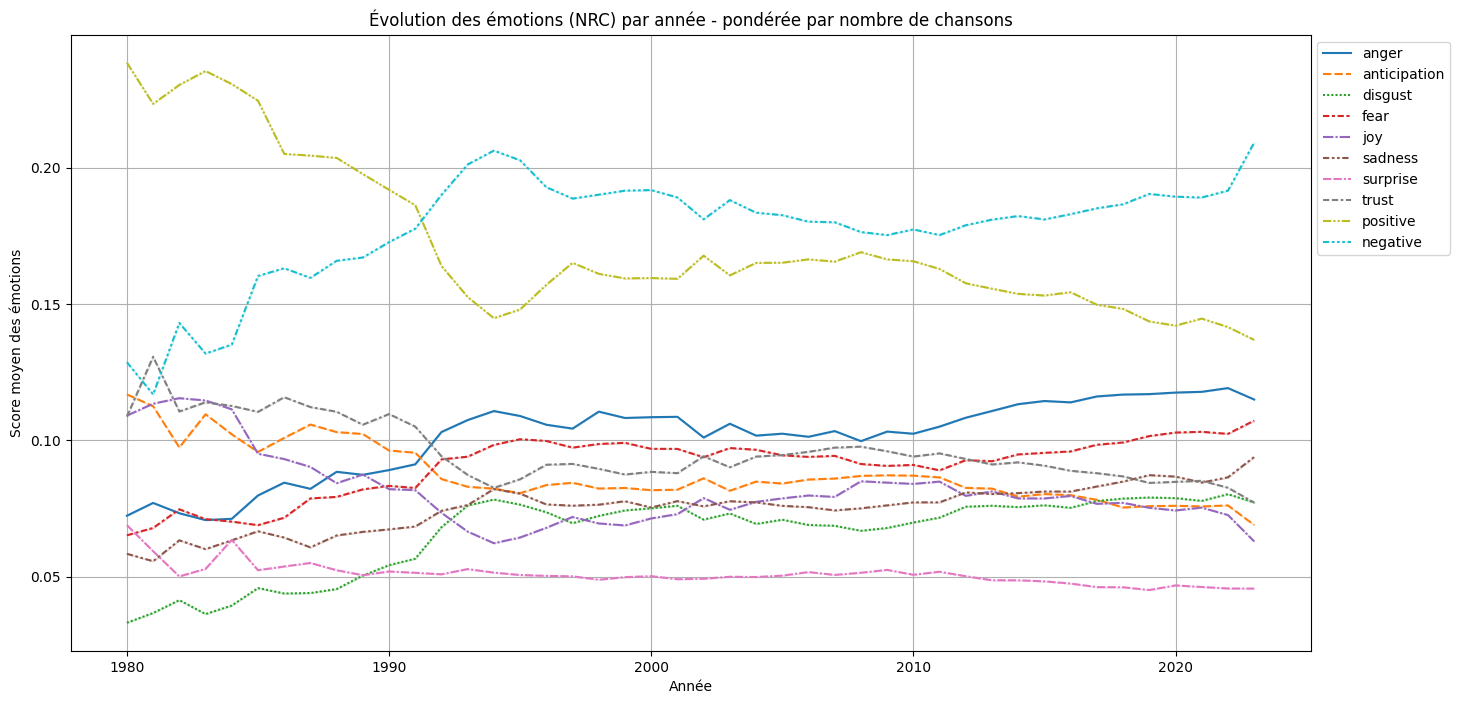

In [ ]:
# Colonnes NRC
nrc_cols = ["anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"]

# 1️⃣ Calcul du nombre de chansons par année
count_per_year = df_top.groupby("year").size()

# 2️⃣ Somme des émotions par année
sum_emotions_per_year = df_top.groupby("year")[nrc_cols].sum()

# Moyenne pondérée en divisant par le nombre de chansons par année
emotion_year_p = sum_emotions_per_year.div(count_per_year, axis=0)

# Graphique
plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year_p)
plt.title("Évolution des émotions (NRC) par année - pondérée par nombre de chansons")
plt.xlabel("Année")
plt.ylabel("Score moyen des émotions")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()